## Name: Rian Rezwan Choudhury
## Student id: 228801132 

## Subject-Independent Human Activity Recognition Using PAMAP2

**Assignment:** Final Project (HAR)
**Goal:** Build a complete, leakage-safe HAR pipeline: load and clean the PAMAP2-style sensor data, explore label/sensor distributions, engineer window-level features, split by subject (train/val/test), train and evaluate models (MLP + classic baselines), and report metrics and error analysis.

## 1. Data Loading and Integration
Load the PAMAP2 subject `.dat` files (or a cached pickle if it already exists) in a **memory-safe** way. The code:
- builds meaningful column names, adds `subject_id`, and concatenates subjects
- keeps a **modeling-ready subset** of columns (labels + `heart_rate` + acc16/gyro/mag for hand/chest/ankle) to reduce RAM usage
- filters out transient rows (`activity == 0`)
- forward-fills `heart_rate` **within each subject** after sorting by `timestamp`
- prints basic sanity checks (shape, subjects, label counts, remaining NaNs)


In [1]:
# 1. Data Loading and Integration (memory-safe)
import os
import numpy as np
import pandas as pd

data_path = "data"   # folder containing subject101.dat ... subject109.dat
combined_cache = os.path.join(data_path, "combined_df.pkl")
final_clean_cache = os.path.join(data_path, "final_clean_df.pkl")

def imu_columns(prefix: str):
    # 17 columns per IMU as described in the dataset doc
    cols = []
    cols.append(f"{prefix}_temp")
    cols += [f"{prefix}_acc16_x", f"{prefix}_acc16_y", f"{prefix}_acc16_z"]
    cols += [f"{prefix}_acc6_x",  f"{prefix}_acc6_y",  f"{prefix}_acc6_z"]
    cols += [f"{prefix}_gyro_x", f"{prefix}_gyro_y",  f"{prefix}_gyro_z"]
    cols += [f"{prefix}_mag_x",  f"{prefix}_mag_y",   f"{prefix}_mag_z"]
    cols += [f"{prefix}_orient_1", f"{prefix}_orient_2", f"{prefix}_orient_3", f"{prefix}_orient_4"]
    return cols

def build_final_clean_df_from_dat(data_path: str, out_path: str) -> pd.DataFrame:
    # Build full column name list (54 columns) to map indices -> names
    col_names = ["timestamp", "activity", "heart_rate"]
    col_names += imu_columns("hand")
    col_names += imu_columns("chest")
    col_names += imu_columns("ankle")
    if len(col_names) != 54:
        raise ValueError(f"Expected 54 columns but got {len(col_names)}")

    # We only need a subset to keep memory low (matches downstream feature selection)
    wanted_names = [
        "timestamp", "activity", "heart_rate",
        # Hand
        "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
        "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
        "hand_mag_x", "hand_mag_y", "hand_mag_z",
        # Chest
        "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
        "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
        "chest_mag_x", "chest_mag_y", "chest_mag_z",
        # Ankle
        "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
        "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
        "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    ]
    wanted_idx = sorted([col_names.index(n) for n in wanted_names])
    wanted_col_names = [col_names[i] for i in wanted_idx]

    files = sorted([f for f in os.listdir(data_path) if f.endswith(".dat")])
    if not files:
        raise FileNotFoundError(f"No .dat files found in {data_path}. Check path and filenames.")

    frames = []
    for file_name in files:
        subject_id = int(file_name.replace("subject", "").replace(".dat", ""))
        file_path = os.path.join(data_path, file_name)

        # Read only the needed columns (dramatically reduces RAM)
        df = pd.read_csv(file_path, sep=r"\s+", header=None, usecols=wanted_idx)
        df.columns = wanted_col_names
        df["subject_id"] = np.int16(subject_id)

        # Remove transient rows early
        df = df.loc[df["activity"].ne(0)].copy()

        # Sort within subject and forward-fill HR within subject only
        df = df.sort_values("timestamp").reset_index(drop=True)
        df["heart_rate"] = df["heart_rate"].ffill()

        # Reduce memory footprint
        float_cols = [c for c in df.columns if c not in ["activity", "subject_id"]]
        df[float_cols] = df[float_cols].astype(np.float32, copy=False)
        df["activity"] = df["activity"].astype(np.int16, copy=False)

        frames.append(df)

    data_final = pd.concat(frames, ignore_index=True)
    data_final.to_pickle(out_path)
    return data_final

# Prefer loading the smaller cleaned cache first (fits in RAM better than combined_df.pkl)
if os.path.exists(final_clean_cache):
    data = pd.read_pickle(final_clean_cache)
    print("Loaded cached cleaned DataFrame:", final_clean_cache)
else:
    # If combined cache exists, try it, but fall back if it fails due to memory/corruption
    if os.path.exists(combined_cache):
        try:
            data = pd.read_pickle(combined_cache)
            print("Loaded cached combined DataFrame:", combined_cache)
        except (MemoryError, SystemError, Exception) as e:
            print("Could not load combined_df.pkl (likely too large or corrupted). Rebuilding cleaned cache from .dat files...")
            print("Reason:", repr(e))
            data = build_final_clean_df_from_dat(data_path, final_clean_cache)
            print("Saved cleaned dataset to:", final_clean_cache)
    else:
        data = build_final_clean_df_from_dat(data_path, final_clean_cache)
        print("Saved cleaned dataset to:", final_clean_cache)

# Basic verification and quick look
print("Total samples:", data.shape[0])
print("Total columns (including subject_id):", data.shape[1])
print("Unique subjects (count):", data["subject_id"].nunique(), sorted(data["subject_id"].unique()))
print("Activity ID value counts (top 10):")
print(data["activity"].value_counts().head(10))

if "heart_rate" in data.columns:
    print("\nRemaining NaNs in heart_rate:", int(data["heart_rate"].isna().sum()))

# show first rows
data.head()

Loaded cached cleaned DataFrame: data\final_clean_df.pkl
Total samples: 1942872
Total columns (including subject_id): 55
Unique subjects (count): 9 [101, 102, 103, 104, 105, 106, 107, 108, 109]
Activity ID value counts (top 10):
activity
4     238761
17    238690
1     192523
3     189931
7     188107
2     185188
16    175353
6     164600
12    117216
13    104944
Name: count, dtype: int64

Remaining NaNs in heart_rate: 42


,timestamp,activity,heart_rate,hand_temp,hand_acc16_x,hand_acc16_y,hand_acc16_z,hand_acc6_x,hand_acc6_y,hand_acc6_z,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orient_1,ankle_orient_2,ankle_orient_3,ankle_orient_4,subject_id
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0,101
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0,101
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0,101
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0,101
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0,101


## Step 2: Understanding the Dataset Structure (Brief)

Purpose:
Verify the structure of the **currently loaded** dataset (`data`) from Step 1 (typically the cleaned, column-reduced cache used for modeling) by checking size, column names, subjects, and missing values.

In [2]:
# Step 2: Understanding the Dataset Structure

# Number of samples and features
print("Total samples:", data.shape[0])
print("Total columns:", data.shape[1])

# Unique subjects
print("Unique subjects (count):", data["subject_id"].nunique())
print("Subjects:", sorted(data["subject_id"].unique()))

# Feature overview
print("\nFirst 10 column names:")
print(list(data.columns[:10]))

# Check missing values
missing = data.isna().sum()
print("\nColumns with missing values (top 10):")
print(missing[missing > 0].sort_values(ascending=False).head(10))


Total samples: 1942872
Total columns: 55
Unique subjects (count): 9
Subjects: [101, 102, 103, 104, 105, 106, 107, 108, 109]

First 10 column names:
['timestamp', 'activity', 'heart_rate', 'hand_temp', 'hand_acc16_x', 'hand_acc16_y', 'hand_acc16_z', 'hand_acc6_x', 'hand_acc6_y', 'hand_acc6_z']

Columns with missing values (top 10):
hand_orient_4    11124
hand_gyro_y      11124
hand_orient_3    11124
hand_orient_2    11124
hand_orient_1    11124
hand_mag_z       11124
hand_mag_x       11124
hand_gyro_z      11124
hand_mag_y       11124
hand_gyro_x      11124
dtype: int64


## 3. Data Cleaning and Filtering

## Objective
Load the **cleaned cached dataset** produced earlier and verify it is suitable for feature extraction and modeling.

## What the code actually does
- Loads `data/final_clean_df.pkl` (created in Step 1/4).
- Ensures **transient samples** (`activity == 0`) are already removed (this happens when building the cache).
- Uses **subject-wise forward fill** for `heart_rate` when building the cache.
- Reports remaining missing values **without dropping rows** at this step.

## Outcome
You now have a subject-consistent, transient-filtered dataset ready for feature selection and windowing. Any remaining NaNs are handled later (Step 7 uses `nanmean/nanstd`, and Step 8 imputes using **training-set means only**).

In [3]:
import os
import pandas as pd
import numpy as np

# Step 3: Data Cleaning and Filtering (memory-safe)
# NOTE: We avoid loading the huge combined_df.pkl here. Instead, we use the cleaned cache built in Step 1/4.

final_clean_cache = "data/final_clean_df.pkl"
if not os.path.exists(final_clean_cache):
    raise FileNotFoundError(
        "Missing data/final_clean_df.pkl. Run Step 1 (Cell 2) first to build the cleaned cache from .dat files."
    )

data_clean = pd.read_pickle(final_clean_cache)

print("Loaded cleaned dataset:", final_clean_cache)
print("Samples:", data_clean.shape[0])
print("Columns:", data_clean.shape[1])
print("Unique activities:", sorted(data_clean["activity"].unique()))
print("Unique subjects:", sorted(data_clean["subject_id"].unique()))

# Quick missing-value summary (do not drop rows here)
missing_total = int(data_clean.isna().sum().sum())
missing_by_col = data_clean.isna().sum().sort_values(ascending=False)
print("\nTotal missing values (all columns):", missing_total)
print("Top columns with missing values:")
print(missing_by_col[missing_by_col > 0].head(10))

Loaded cleaned dataset: data/final_clean_df.pkl
Samples: 1942872
Columns: 55
Unique activities: [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
Unique subjects: [101, 102, 103, 104, 105, 106, 107, 108, 109]

Total missing values (all columns): 374909
Top columns with missing values:
hand_orient_2    11124
hand_gyro_x      11124
hand_orient_4    11124
hand_orient_3    11124
hand_orient_1    11124
hand_mag_z       11124
hand_mag_y       11124
hand_mag_x       11124
hand_gyro_y      11124
hand_gyro_z      11124
dtype: int64


## Step 4: Missing Value Analysis / Handling (Leakage-Safe)

In this step, we **quantify** missing values after two cleaning actions already applied while building/loading the cleaned cache:
- removing transient rows (`activity == 0`)
- subject-wise forward fill of `heart_rate`

> No global imputation is performed here.

Any remaining NaNs are handled in a leakage-safe way later:
- Step 7 uses `nanmean` / `nanstd` when computing window statistics
- Step 8 imputes remaining NaNs using **training-set feature means only** (then fits the scaler on training only)

In [4]:
import os
import pandas as pd
import numpy as np

# Step 4: Handling Missing Values (memory-safe)
# If the cleaned cache already exists (recommended), load it. Otherwise, build it from .dat files using a low-memory reader.

data_path = "data"
final_clean_cache = os.path.join(data_path, "final_clean_df.pkl")

def imu_columns(prefix: str):
    cols = []
    cols.append(f"{prefix}_temp")
    cols += [f"{prefix}_acc16_x", f"{prefix}_acc16_y", f"{prefix}_acc16_z"]
    cols += [f"{prefix}_acc6_x",  f"{prefix}_acc6_y",  f"{prefix}_acc6_z"]
    cols += [f"{prefix}_gyro_x", f"{prefix}_gyro_y",  f"{prefix}_gyro_z"]
    cols += [f"{prefix}_mag_x",  f"{prefix}_mag_y",   f"{prefix}_mag_z"]
    cols += [f"{prefix}_orient_1", f"{prefix}_orient_2", f"{prefix}_orient_3", f"{prefix}_orient_4"]
    return cols

def build_final_clean_df_from_dat(data_path: str, out_path: str) -> pd.DataFrame:
    col_names = ["timestamp", "activity", "heart_rate"]
    col_names += imu_columns("hand")
    col_names += imu_columns("chest")
    col_names += imu_columns("ankle")
    if len(col_names) != 54:
        raise ValueError(f"Expected 54 columns but got {len(col_names)}")

    wanted_names = [
        "timestamp", "activity", "heart_rate",
        # Hand
        "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
        "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
        "hand_mag_x", "hand_mag_y", "hand_mag_z",
        # Chest
        "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
        "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
        "chest_mag_x", "chest_mag_y", "chest_mag_z",
        # Ankle
        "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
        "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
        "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    ]
    wanted_idx = sorted([col_names.index(n) for n in wanted_names])
    wanted_col_names = [col_names[i] for i in wanted_idx]

    files = sorted([f for f in os.listdir(data_path) if f.endswith(".dat")])
    if not files:
        raise FileNotFoundError(f"No .dat files found in {data_path}. Check path and filenames.")

    frames = []
    for file_name in files:
        subject_id = int(file_name.replace("subject", "").replace(".dat", ""))
        file_path = os.path.join(data_path, file_name)

        df = pd.read_csv(file_path, sep=r"\s+", header=None, usecols=wanted_idx)
        df.columns = wanted_col_names
        df["subject_id"] = np.int16(subject_id)

        # Remove transient activity (activity == 0)
        df = df.loc[df["activity"].ne(0)].copy()

        # Sort and forward-fill HR within subject only
        df = df.sort_values("timestamp").reset_index(drop=True)
        df["heart_rate"] = df["heart_rate"].ffill()

        # Reduce memory footprint
        float_cols = [c for c in df.columns if c not in ["activity", "subject_id"]]
        df[float_cols] = df[float_cols].astype(np.float32, copy=False)
        df["activity"] = df["activity"].astype(np.int16, copy=False)

        frames.append(df)

    data_final = pd.concat(frames, ignore_index=True)
    data_final.to_pickle(out_path)
    return data_final

if os.path.exists(final_clean_cache):
    data = pd.read_pickle(final_clean_cache)
    print("Loaded cleaned dataset from:", final_clean_cache)
else:
    data = build_final_clean_df_from_dat(data_path, final_clean_cache)
    print("Built + saved cleaned dataset to:", final_clean_cache)

missing_total = int(data.isna().sum().sum())
print("Remaining missing values after subject-wise HR ffill:", missing_total)
print("Final samples (activity != 0):", data.shape[0])
print("Remaining NaNs in heart_rate:", int(data["heart_rate"].isna().sum()))

Loaded cleaned dataset from: data\final_clean_df.pkl
Remaining missing values after subject-wise HR ffill: 374909
Final samples (activity != 0): 1942872
Remaining NaNs in heart_rate: 42


## 5. Label and Class Distribution Analysis

## Objective
Analyze the distribution of activity labels to identify class imbalance.

## Importance
Some activities contain significantly fewer samples. Understanding class imbalance helps in selecting appropriate evaluation metrics and applying balancing strategies during model training.


Using in-memory data_clean for class distribution.
Samples per activity:
activity
1     192523
2     185188
3     189931
4     238761
5      98199
6     164600
7     188107
12    117216
13    104944
16    175353
17    238690
24     49360
Name: count, dtype: int64

Present activity IDs: [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
Missing expected activity IDs (if any): [9, 10, 11, 18, 19, 20]


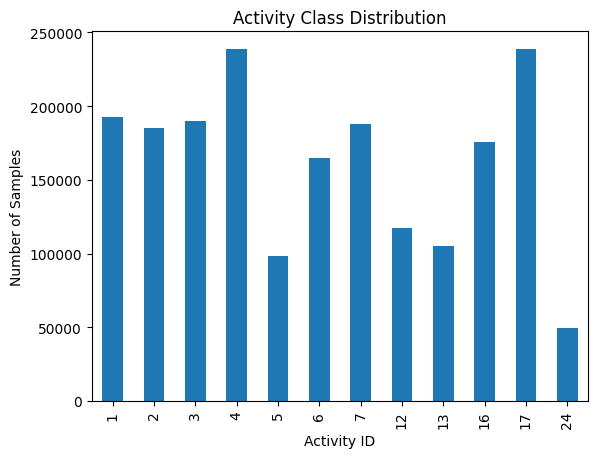

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 5: Label and Class Distribution Analysis (memory-safe)
# Prefer using an in-memory DataFrame (from Step 1/3/4) to avoid re-loading large pickles.
# Fallback: stream only the activity column from .dat files to compute counts with low RAM.

def compute_activity_counts_streaming(data_path: str = "data") -> pd.Series:
    files = sorted([f for f in os.listdir(data_path) if f.endswith(".dat")])
    if not files:
        raise FileNotFoundError(f"No .dat files found in {data_path}")

    total_counts = {}
    for f in files:
        fp = os.path.join(data_path, f)
        # Column 1 is activity in PAMAP2 format: [timestamp, activity, heart_rate, ...]
        s = pd.read_csv(fp, sep=r"\s+", header=None, usecols=[1])[1]
        s = s[s.ne(0)]  # remove transient
        vc = s.value_counts()
        for k, v in vc.items():
            total_counts[int(k)] = total_counts.get(int(k), 0) + int(v)
    return pd.Series(total_counts).sort_index()

if "data_clean" in globals() and isinstance(globals().get("data_clean"), pd.DataFrame) and "activity" in data_clean.columns:
    df_for_counts = data_clean
    print("Using in-memory data_clean for class distribution.")
    class_counts = df_for_counts["activity"].value_counts().sort_index()
elif "data" in globals() and isinstance(globals().get("data"), pd.DataFrame) and "activity" in data.columns:
    df_for_counts = data
    print("Using in-memory data for class distribution.")
    class_counts = df_for_counts["activity"].value_counts().sort_index()
else:
    print("No in-memory dataset found; streaming activity counts from .dat files...")
    class_counts = compute_activity_counts_streaming("data")

print("Samples per activity:")
print(class_counts)

# Optional: show which expected activity IDs are missing in the provided files
expected_activity_ids = [1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24]
present = sorted(class_counts.index.tolist())
missing = sorted(set(expected_activity_ids) - set(present))
print("\nPresent activity IDs:", present)
print("Missing expected activity IDs (if any):", missing)

plt.figure()
class_counts.plot(kind="bar")
plt.xlabel("Activity ID")
plt.ylabel("Number of Samples")
plt.title("Activity Class Distribution")
plt.show()

## 5B. Quick Sensor EDA (Memory-Safe)

This short EDA section adds a bit more exploration of **sensor readings** (beyond label counts) while staying lightweight:
- sample a small subset of rows to avoid heavy RAM usage
- visualize per-activity distributions for a few representative channels
- inspect missingness rates for the selected signals

These plots help sanity-check signal ranges and whether activities are separable based on raw channels.

In [6]:
# Step 5B: Sensor EDA (setup + sampling only)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose a source dataframe without forcing large re-loads
if "data_clean" in globals() and isinstance(globals().get("data_clean"), pd.DataFrame):
    eda_src = data_clean
    print("EDA source: data_clean")
elif "data" in globals() and isinstance(globals().get("data"), pd.DataFrame):
    eda_src = data
    print("EDA source: data")
else:
    raise RuntimeError("No dataset found in memory. Run Step 1/3/4 first.")

# Keep only columns we need for EDA
candidate_features = [
    "heart_rate",
    "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
    "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
    "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
    "hand_gyro_x", "chest_gyro_x", "ankle_gyro_x",
    "hand_mag_x", "chest_mag_x", "ankle_mag_x",
]
cols = [c for c in (["activity"] + candidate_features) if c in eda_src.columns]
eda_df = eda_src[cols]

# Sample to keep plots fast (cap rows per activity)
MAX_PER_CLASS = 5000
sample_parts = []
for act, grp in eda_df.groupby("activity", sort=False):
    if int(act) == 0:
        continue
    if grp.shape[0] > MAX_PER_CLASS:
        sample_parts.append(grp.sample(n=MAX_PER_CLASS, random_state=42))
    else:
        sample_parts.append(grp)
eda_sample = pd.concat(sample_parts, ignore_index=True)
print("EDA sample shape:", eda_sample.shape)

# Helper: ensure we have the EDA sample before plotting
def _require_eda_sample():
    if "eda_sample" not in globals():
        raise RuntimeError("eda_sample not found. Run the Step 5B setup cell first.")

def plot_box_by_activity(feat: str):
    _require_eda_sample()
    if feat not in eda_sample.columns:
        raise KeyError(f"Feature not found in eda_sample: {feat}")
    tmp = eda_sample[["activity", feat]].dropna()
    if tmp.empty:
        print(f"No non-missing values for {feat} in the EDA sample.")
        return
    if tmp.shape[0] > 60000:
        tmp = tmp.sample(n=60000, random_state=42)
    acts = sorted(tmp["activity"].unique().tolist())
    data_by_act = [tmp.loc[tmp["activity"] == a, feat].values for a in acts]
    plt.figure(figsize=(max(10, 0.6 * len(acts)), 4))
    plt.boxplot(data_by_act, labels=[str(a) for a in acts], showfliers=False)
    plt.title(f"{feat}: distribution by activity (sampled)")
    plt.xlabel("Activity ID")
    plt.ylabel(feat)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_missingness():
    _require_eda_sample()
    miss = eda_sample.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    if len(miss) == 0:
        print("No missing values in sampled EDA columns.")
        return
    plt.figure(figsize=(10, max(3, 0.3 * len(miss))))
    plt.barh(miss.index[::-1], (miss.values[::-1] * 100.0))
    plt.xlabel("Missing rate (%)")
    plt.title("Missingness by column (EDA sample)")
    plt.tight_layout()
    plt.show()

def plot_corr_heatmap():
    _require_eda_sample()
    num_cols = [c for c in eda_sample.columns if c != "activity"]
    corr_df = eda_sample[num_cols].astype(np.float32, errors="ignore")
    corr_df = corr_df.dropna(axis=1, how="all")
    corr_df = corr_df.fillna(corr_df.mean(numeric_only=True))
    if corr_df.shape[1] < 2:
        print("Not enough numeric columns for correlation heatmap.")
        return
    corr = corr_df.corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="corr")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Feature correlation heatmap (EDA sample)")
    plt.tight_layout()
    plt.show()

EDA source: data_clean
EDA sample shape: (60000, 17)


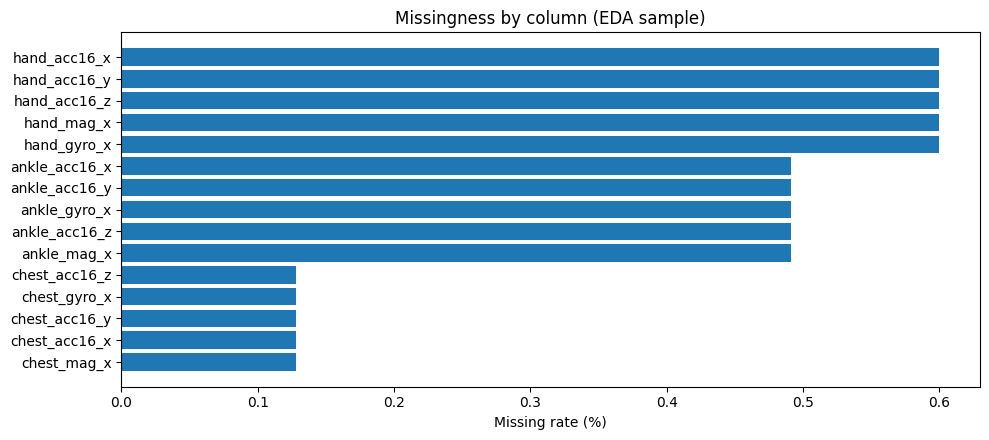

In [7]:
# Step 5B.1 Missingness by column
plot_missingness()

C:\Users\HP\AppData\Local\Temp\ipykernel_14212\1249211831.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_act, labels=[str(a) for a in acts], showfliers=False)


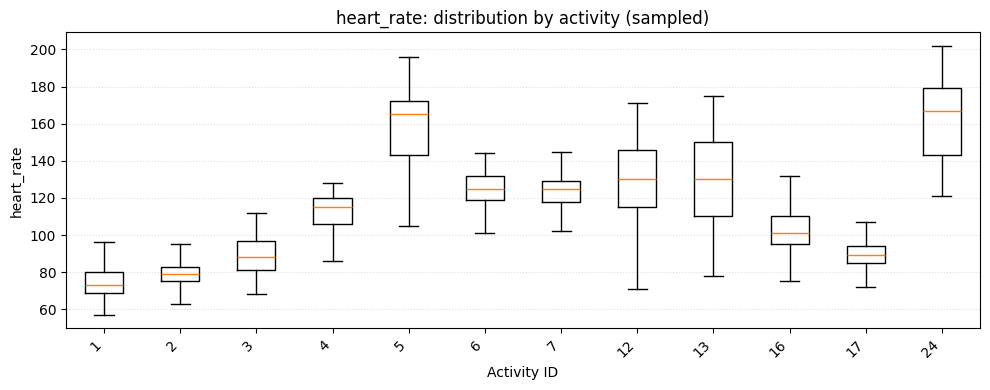

In [8]:
# Step 5B.2 Boxplot: heart_rate
plot_box_by_activity("heart_rate")

C:\Users\HP\AppData\Local\Temp\ipykernel_14212\1249211831.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_act, labels=[str(a) for a in acts], showfliers=False)


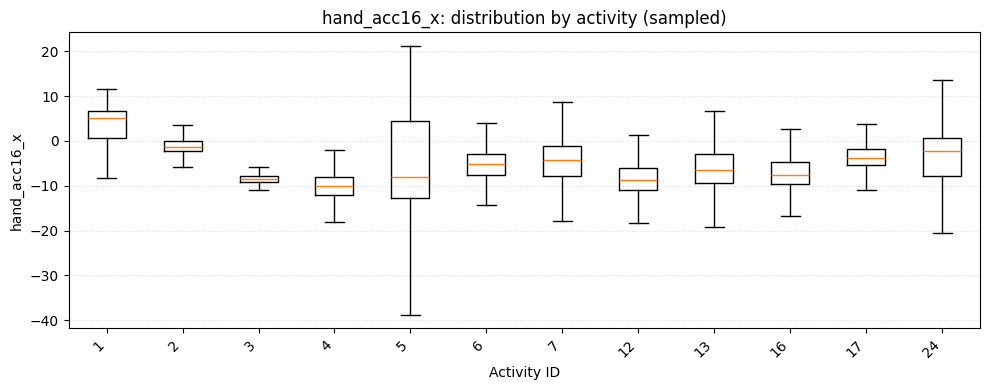

In [9]:
# Step 5B.3 Boxplot: hand_acc16_x
plot_box_by_activity("hand_acc16_x")

C:\Users\HP\AppData\Local\Temp\ipykernel_14212\1249211831.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_act, labels=[str(a) for a in acts], showfliers=False)


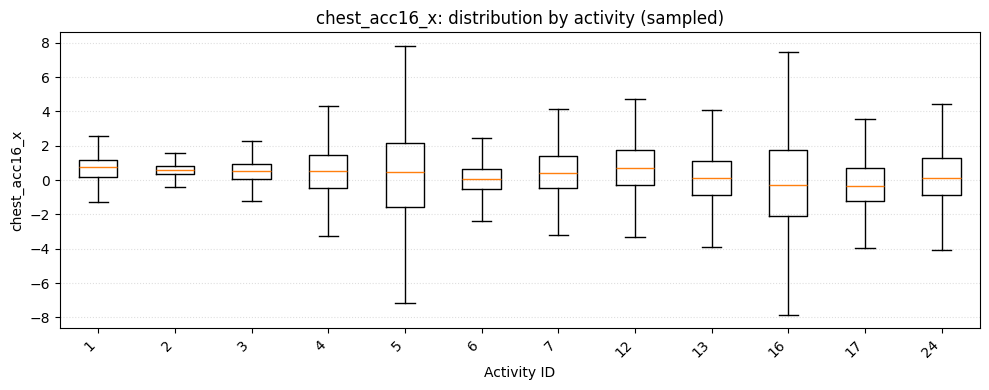

In [10]:
# Step 5B.4 Boxplot: chest_acc16_x
plot_box_by_activity("chest_acc16_x")

C:\Users\HP\AppData\Local\Temp\ipykernel_14212\1249211831.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_act, labels=[str(a) for a in acts], showfliers=False)


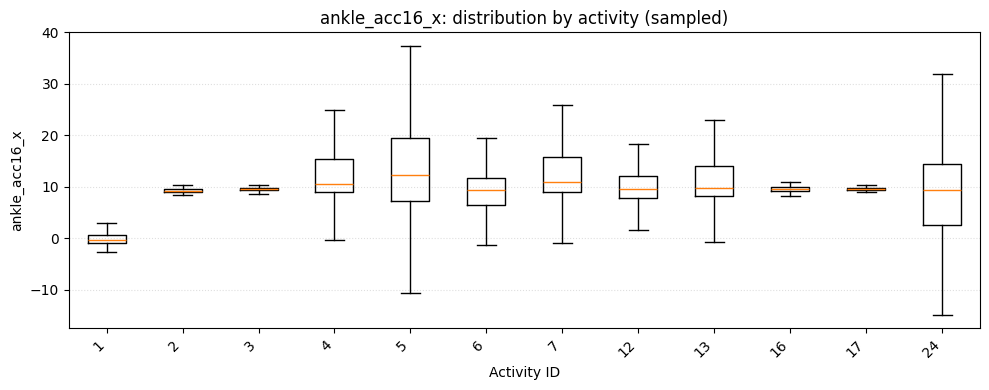

In [11]:
# Step 5B.5 Boxplot: ankle_acc16_x
plot_box_by_activity("ankle_acc16_x")

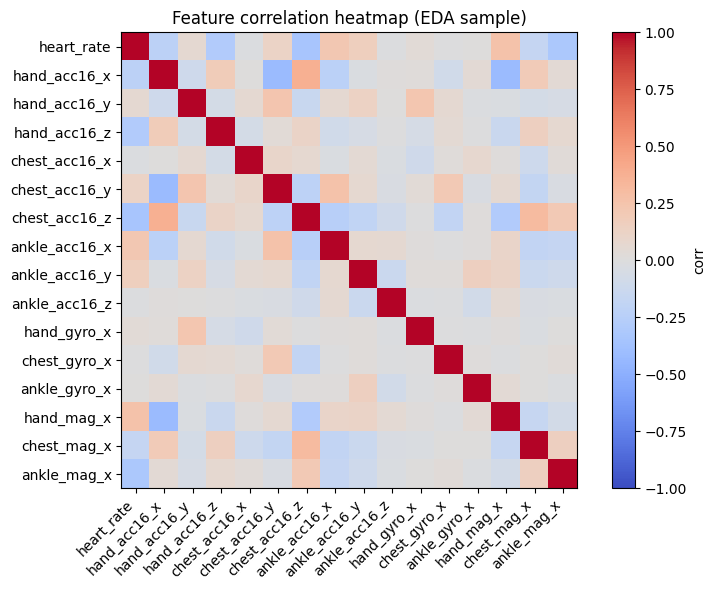

In [12]:
# Step 5B.6 Correlation heatmap
plot_corr_heatmap()

## 6. Feature Selection (Initial)

## Goal
Use a compact set of reliable signals for model training (and keep memory usage manageable).

## What happens here
- Keep labels: `activity`, `subject_id`
- Keep physiology: `heart_rate`
- Keep IMU signals from **Hand/Chest/Ankle**:
  - accelerometer (±16g): `*_acc16_*`
  - gyroscope: `*_gyro_*`
  - magnetometer: `*_mag_*`
- Exclude other channels not used downstream (e.g., orientation/quaternions, ±6g accelerometer, temperature)
- Create `data_selected` as a **view** (not a deep copy) to avoid high RAM usage

## Why it matters
- Reduces dimensionality while keeping informative motion signals
- Improves training speed and stability
- Avoids `MemoryError` by not duplicating the full DataFrame

In [13]:
# Step 6: Feature Selection (Improved, ultra memory-safe)
# Key change: DO NOT do `src[selected_columns].copy()` (can allocate hundreds of MB).
# We keep a lightweight view and let Step 7 window per-subject.

import pandas as pd

# Pick a source dataframe without forcing a new pickle load
if "data_clean" in globals() and isinstance(globals().get("data_clean"), pd.DataFrame):
    src = data_clean
    print("Using in-memory data_clean as feature source.")
elif "data" in globals() and isinstance(globals().get("data"), pd.DataFrame):
    src = data
    print("Using in-memory data as feature source.")
else:
    raise RuntimeError("No in-memory dataset found. Run Cell 2 (Step 1) first.")

selected_columns = [
    # Labels
    "activity",
    "subject_id",

    # Heart rate
    "heart_rate",

    # Hand
    "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
    "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
    "hand_mag_x", "hand_mag_y", "hand_mag_z",

    # Chest
    "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
    "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
    "chest_mag_x", "chest_mag_y", "chest_mag_z",

    # Ankle
    "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
    "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
    "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
]

missing_cols = [c for c in selected_columns if c not in src.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns in data: {missing_cols}")

# IMPORTANT: keep a view (no deep copy) to avoid MemoryError
data_selected = src[selected_columns]

print("Selected columns (incl. labels):", len(data_selected.columns))
print("Feature columns:", [c for c in data_selected.columns if c not in ["activity", "subject_id"]])
print("Samples after feature selection:", data_selected.shape[0])

Using in-memory data_clean as feature source.
Selected columns (incl. labels): 30
Feature columns: ['heart_rate', 'hand_acc16_x', 'hand_acc16_y', 'hand_acc16_z', 'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z', 'hand_mag_x', 'hand_mag_y', 'hand_mag_z', 'chest_acc16_x', 'chest_acc16_y', 'chest_acc16_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'ankle_acc16_x', 'ankle_acc16_y', 'ankle_acc16_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z']
Samples after feature selection: 1942872


## 7. Feature Preparation (Time-Window Features, Leakage-Free)

## Goal
Convert raw high-frequency sensor streams into **windowed samples** so the model learns from short time segments (temporal context).

## What happens here
- Build fixed-length sliding windows per subject.
- For each window, compute simple statistics (mean + std) for each sensor channel.
- Assign a window label using majority vote (and skip mixed-transition windows).

## Why this helps
- Reduces noise and makes the task closer to the true HAR setup (time-series).
- Usually improves **macro F1**, because minority classes become easier to separate with temporal context.
- Greatly reduces the number of training steps per epoch compared to training on every 100Hz sample.

## Leakage note
We still do **no scaling here**. Scaling and remaining-NaN imputation are done in Step 8 using **training data only**.

In [14]:
# Step 7: Prepare Windowed Features (subject-by-subject, low RAM)
import numpy as np
from collections import Counter

# We expect `data_selected` from Step 6, which is a lightweight view with columns:
# activity, subject_id, and selected sensor features.

WINDOW_SIZE = 100
STEP_SIZE = 50
MAJORITY_THRESHOLD = 0.80  # require label stability within window

feature_cols = [c for c in data_selected.columns if c not in ["activity", "subject_id"]]

X_windows = []
y_windows = []
g_windows = []

# Process one subject at a time to avoid building a huge (N x D) array in memory
grouped = data_selected.groupby("subject_id", sort=False)
for subj, grp in grouped:
    if grp.shape[0] < WINDOW_SIZE:
        continue

    # Convert only this subject to numpy (bounded memory)
    X_s = grp[feature_cols].to_numpy(dtype=np.float32, copy=True)
    y_s = grp["activity"].to_numpy(copy=False)

    # Sliding windows
    for start in range(0, X_s.shape[0] - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE
        y_w = y_s[start:end]
        counts = Counter(y_w)
        label, cnt = counts.most_common(1)[0]
        if cnt / WINDOW_SIZE < MAJORITY_THRESHOLD:
            continue

        X_w = X_s[start:end]
        feat_mean = np.nanmean(X_w, axis=0)
        feat_std = np.nanstd(X_w, axis=0)
        feat = np.concatenate([feat_mean, feat_std], axis=0).astype(np.float32)

        X_windows.append(feat)
        y_windows.append(label)
        g_windows.append(subj)

X_raw = np.asarray(X_windows, dtype=np.float32)
y = np.asarray(y_windows)
subjects = np.asarray(g_windows)

print("Windowing complete")
print("Per-window feature dim:", X_raw.shape[1], f"(2 * {len(feature_cols)} raw features)")
print("X_raw (windows) shape:", X_raw.shape)
print("y (windows) shape:", y.shape)
print("subjects (windows) shape:", subjects.shape)
print("Unique activities in windows:", len(np.unique(y)), sorted(np.unique(y)))
print("Unique subjects in windows:", len(np.unique(subjects)), sorted(np.unique(subjects)))

# Useful for debugging macro-F1 issues: check class distribution after windowing
counts = Counter(y.tolist())
print("\nWindow label counts (top 10):")
for k, v in sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10]:
    print(f"  Activity {k}: {v}")

Windowing complete
Per-window feature dim: 56 (2 * 28 raw features)
X_raw (windows) shape: (38734, 56)
y (windows) shape: (38734,)
subjects (windows) shape: (38734,)
Unique activities in windows: 12 [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
Unique subjects in windows: 9 [101, 102, 103, 104, 105, 106, 107, 108, 109]

Window label counts (top 10):
  Activity 4: 4766
  Activity 17: 4765
  Activity 1: 3843
  Activity 3: 3791
  Activity 7: 3753
  Activity 2: 3695
  Activity 16: 3497
  Activity 6: 3283
  Activity 12: 2327
  Activity 13: 2079


## Step 8: Subject-Independent Train / Validation / Test Split

In this step, we split the windowed dataset by **subject IDs** (not by individual windows) to prevent leakage—no subject appears in more than one split.

## Split definition (fixed and reproducible)
- Train subjects: `[101, 105, 106, 107, 108]`
- Validation subjects: `[102, 104]`
- Test subjects: `[103, 109]`

## Leakage-safe preprocessing
- Impute remaining NaNs using **training-set feature means only**
- Fit `StandardScaler` using **training data only**, then transform val/test
- Fit `LabelEncoder` using **training labels only**
- Compute class weights using **training labels only**

## Guardrail
If validation/test contain activity labels that do not appear in training, those windows are **removed from evaluation** (so metrics reflect performance on train-known classes under a subject-independent split).

In [15]:
# Step 8: Subject-independent Train/Val/Test split + train-only imputation + train-only scaling
import os
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# ======= Inputs expected from Step 7 =======
# X_raw     -> numpy array shape (N, num_features) (windowed features)
# y         -> numpy array shape (N,) (window labels)
# subjects  -> numpy array shape (N,) (window subject_id)
# ==========================================
X_all = np.asarray(X_raw)
y_all = np.asarray(y)
g_all = np.asarray(subjects)

unique_subjects = sorted(np.unique(g_all).tolist())
all_labels = sorted(np.unique(y_all).tolist())

print("All subjects:", unique_subjects)
print("All activity labels (in windows):", all_labels)

# ------------------------------
# Fixed, grading-safe subject split
# ------------------------------
train_subjects = [101, 105, 106, 107, 108]
val_subjects   = [102, 104]
test_subjects  = [103, 109]

# Validate the chosen subjects exist in the dataset
for name, subj_list in [("train", train_subjects), ("val", val_subjects), ("test", test_subjects)]:
    missing = [s for s in subj_list if s not in unique_subjects]
    if missing:
        raise ValueError(f"Chosen {name} subjects not found in dataset: {missing}. Available: {unique_subjects}")

# Verify no overlaps
if (set(train_subjects) & set(val_subjects)) or (set(train_subjects) & set(test_subjects)) or (set(val_subjects) & set(test_subjects)):
    raise ValueError("Subject overlap detected between train/val/test. Fix the subject lists.")

train_mask = np.isin(g_all, train_subjects)
val_mask = np.isin(g_all, val_subjects)
test_mask = np.isin(g_all, test_subjects)

X_train_raw, y_train_raw, g_train_raw = X_all[train_mask], y_all[train_mask], g_all[train_mask]
X_val_raw, y_val_raw, g_val_raw = X_all[val_mask], y_all[val_mask], g_all[val_mask]
X_test_raw, y_test_raw, g_test_raw = X_all[test_mask], y_all[test_mask], g_all[test_mask]

print("\nChosen subjects:")
print("Train subjects:", train_subjects)
print("Val subjects:  ", val_subjects)
print("Test subjects: ", test_subjects)

print("\nSplit sizes (samples):")
print("Train:", X_train_raw.shape, "Val:", X_val_raw.shape, "Test:", X_test_raw.shape)

# ---- Train-only NaN imputation (prevents using val/test statistics) ----
def impute_with_train_means(X_tr, *others):
    X_tr = np.asarray(X_tr, dtype=np.float32)
    train_means = np.nanmean(X_tr, axis=0)
    train_means = np.where(np.isnan(train_means), 0.0, train_means).astype(np.float32)

    def fill(X):
        X = np.asarray(X, dtype=np.float32)
        nan_rows, nan_cols = np.where(np.isnan(X))
        if nan_rows.size:
            X[nan_rows, nan_cols] = train_means[nan_cols]
        return X

    X_tr_filled = fill(X_tr)
    filled_others = [fill(x) for x in others]
    return X_tr_filled, filled_others, train_means

X_train_raw, (X_val_raw, X_test_raw), train_feature_means = impute_with_train_means(X_train_raw, X_val_raw, X_test_raw)

print("\nNaNs after train-only imputation:")
print("Train:", int(np.isnan(X_train_raw).sum()), "Val:", int(np.isnan(X_val_raw).sum()), "Test:", int(np.isnan(X_test_raw).sum()))

# ---- Guardrail: if val/test contain labels not present in TRAIN ----
train_label_set = set(np.unique(y_train_raw).tolist())
val_label_set = set(np.unique(y_val_raw).tolist())
test_label_set = set(np.unique(y_test_raw).tolist())

unknown_in_val = sorted(val_label_set - train_label_set)
unknown_in_test = sorted(test_label_set - train_label_set)
if unknown_in_val or unknown_in_test:
    print("\nWARNING: Some activity labels appear in val/test but not in train.")
    if unknown_in_val:
        print("  Unknown labels in VAL (will be removed from val evaluation):", unknown_in_val)
    if unknown_in_test:
        print("  Unknown labels in TEST (will be removed from test evaluation):", unknown_in_test)

    # Filter out unknown-label samples from val/test AND keep subject arrays aligned
    if unknown_in_val:
        keep_val = np.isin(y_val_raw, list(train_label_set))
        removed = int((~keep_val).sum())
        X_val_raw, y_val_raw, g_val_raw = X_val_raw[keep_val], y_val_raw[keep_val], g_val_raw[keep_val]
        print(f"  Removed {removed} val windows with unseen labels.")
    if unknown_in_test:
        keep_test = np.isin(y_test_raw, list(train_label_set))
        removed = int((~keep_test).sum())
        X_test_raw, y_test_raw, g_test_raw = X_test_raw[keep_test], y_test_raw[keep_test], g_test_raw[keep_test]
        print(f"  Removed {removed} test windows with unseen labels.")

print("\nLabels in TRAIN:", sorted(train_label_set))
print("Labels in VAL (after filtering):", sorted(set(np.unique(y_val_raw).tolist())))
print("Labels in TEST (after filtering):", sorted(set(np.unique(y_test_raw).tolist())))

# ---- Label encode (fit on TRAIN only) ----
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_val = label_encoder.transform(y_val_raw)
y_test = label_encoder.transform(y_test_raw)

classes = np.unique(y_train)
num_classes = len(label_encoder.classes_)
print("\nNum classes (train-known):", num_classes)

# ---- Compute class weights (TRAIN only) ----
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("\nClass weights (for training):")
print(class_weight_dict)

# ---- Scaling (fit scaler ONLY on TRAIN) ----
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw).astype(np.float32)
X_val = scaler.transform(X_val_raw).astype(np.float32)
X_test = scaler.transform(X_test_raw).astype(np.float32)

print("\nScaled shapes:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ---- Save artifacts (subjects arrays are aligned with X/y) ----
os.makedirs("data/splits", exist_ok=True)
joblib.dump((X_train, y_train, g_train_raw), "data/splits/train_split.pkl")
joblib.dump((X_val, y_val, g_val_raw), "data/splits/val_split.pkl")
joblib.dump((X_test, y_test, g_test_raw), "data/splits/test_split.pkl")
joblib.dump(class_weight_dict, "data/splits/class_weights.pkl")
joblib.dump(label_encoder, "data/splits/label_encoder.pkl")
joblib.dump(scaler, "data/splits/scaler.pkl")
joblib.dump(train_feature_means, "data/splits/train_feature_means.npy")

print("\nSaved splits + scaler + label encoder to data/splits/")

All subjects: [101, 102, 103, 104, 105, 106, 107, 108, 109]
All activity labels (in windows): [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]

Chosen subjects:
Train subjects: [101, 105, 106, 107, 108]
Val subjects:   [102, 104]
Test subjects:  [103, 109]

Split sizes (samples):
Train: (25268, 56) Val: (9865, 56) Test: (3601, 56)

NaNs after train-only imputation:
Train: 0 Val: 0 Test: 0

Labels in TRAIN: [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
Labels in VAL (after filtering): [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
Labels in TEST (after filtering): [1, 2, 3, 4, 12, 13, 16, 17, 24]

Num classes (train-known): 12

Class weights (for training):
{0: 0.8507744107744107, 1: 0.971696662051992, 2: 0.8854779927109616, 3: 0.7263424169253766, 4: 1.1869597895527997, 5: 0.9037195994277539, 6: 0.8067688378033205, 7: 1.457208765859285, 8: 1.7679820878813322, 9: 0.9235380116959064, 10: 0.6725220909187692, 11: 3.5810657596371884}

Scaled shapes:
Train: (25268, 56) Val: (9865, 56) Test: (3601, 56)

Saved

## Step 9: Multilayer Perceptron (MLP) Classifier — Training + Evaluation

## Goal
Train a feedforward **Multilayer Perceptron (MLP)** classifier on the window-level feature vectors produced in Step 8 and evaluate generalization to unseen subjects.

## Inputs
- `X_train, y_train`: training windows (scaled using training-only statistics)
- `X_val, y_val`: validation windows (used for model selection)
- `X_test, y_test`: held-out test windows (final evaluation)
- `class_weight_dict`: handles class imbalance during training

## Model
A dense neural network (MLP) with regularization (dropout + L2) and noise injection to improve robustness across subjects.

## Training procedure
- Optimize cross-entropy loss with Adam/AdamW.
- Use early stopping and learning-rate reduction.
- Save the best checkpoint based on **validation accuracy**, then reload it before testing.

## Evaluation outputs
The next cell reports:
- Test Accuracy
- Macro-F1 and Weighted-F1
- Per-class classification report
- Confusion matrix (test set)

## Note on interpretation
A small train–validation gap can happen in subject-independent splits due to subject variability. The key metric is how well the best validation checkpoint performs on the held-out test subjects.

Deterministic ops enabled
Label smoothing not supported; using plain SparseCategoricalCrossentropy
Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3216 - loss: 2.6870 - val_accuracy: 0.6104 - val_loss: 1.6510 - learning_rate: 3.0000e-04
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5943 - loss: 1.6470 - val_accuracy: 0.7562 - val_loss: 1.1803 - learning_rate: 3.0000e-04
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7003 - loss: 1.3233 - val_accuracy: 0.7864 - val_loss: 1.0288 - learning_rate: 3.0000e-04
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7558 - loss: 1.1594 - val_accuracy: 0.7998 - val_loss: 0.9527 - learning_rate: 3.0000e-04
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7853 - loss: 1.0478 - val_accuracy: 0.8113 - val_loss: 0.8927 - learning_rate: 3.0000e-04
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8097 - loss: 0.9698 - val_accuracy: 0.8232 - val_

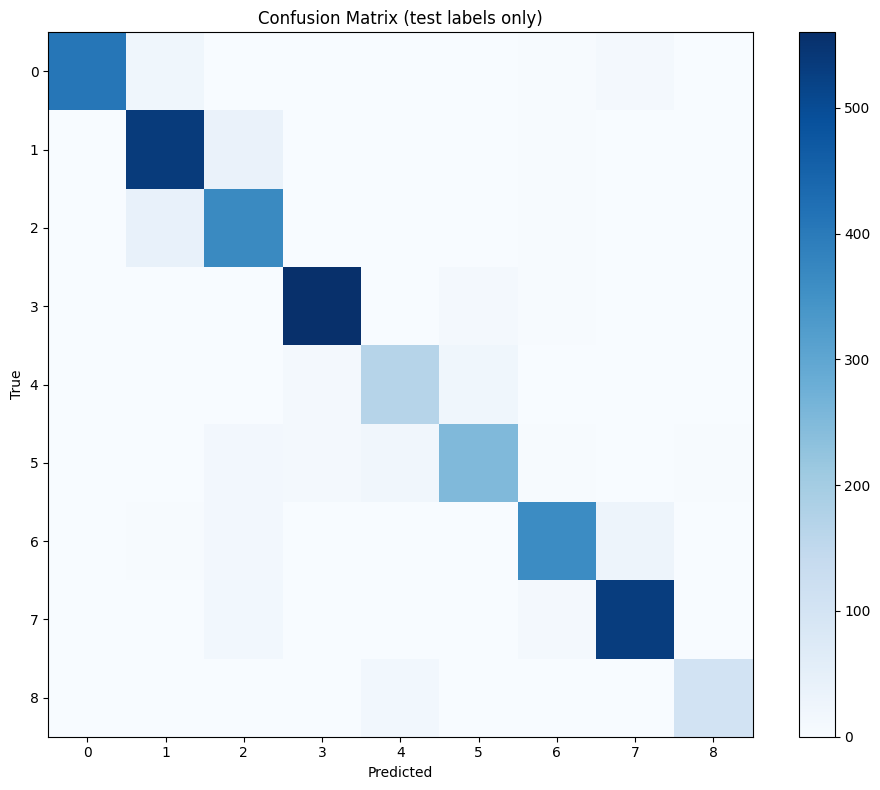


===== FINAL SUMMARY (TEST labels only) =====
accuracy        0.9111   support=3601
micro avg   P=0.9147  R=0.9111  F1=0.9129  support=3601
macro avg   P=0.9127  R=0.8915  F1=0.9009  support=3601
weighted    P=0.9168  R=0.9111  F1=0.9132  support=3601


In [16]:
# Step 9: Model Training — Deep Learning (generalization-first to reach ~0.90 on unseen subjects)

import os
import random
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# --- Load preprocessed splits if not already in memory (from Step 8) ---
if (
    ("X_train" not in globals()) or ("y_train" not in globals()) or
    ("X_val" not in globals()) or ("y_val" not in globals()) or
    ("X_test" not in globals()) or ("y_test" not in globals()) or
    ("class_weight_dict" not in globals()) or ("label_encoder" not in globals())
):
    splits_dir = os.path.join("data", "splits")
    train_fp = os.path.join(splits_dir, "train_split.pkl")
    val_fp   = os.path.join(splits_dir, "val_split.pkl")
    test_fp  = os.path.join(splits_dir, "test_split.pkl")
    cw_fp    = os.path.join(splits_dir, "class_weights.pkl")
    le_fp    = os.path.join(splits_dir, "label_encoder.pkl")

    needed = [train_fp, val_fp, test_fp, cw_fp, le_fp]
    missing = [p for p in needed if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(
            "Missing Step 8 artifacts. Run Step 8 first. Missing: " + ", ".join(missing)
        )

    print("Loading splits from:", splits_dir)
    X_train, y_train, _ = joblib.load(train_fp)
    X_val, y_val, _     = joblib.load(val_fp)
    X_test, y_test, _   = joblib.load(test_fp)
    class_weight_dict   = joblib.load(cw_fp)
    label_encoder       = joblib.load(le_fp)

num_classes = len(label_encoder.classes_)

# --- Reproducibility ---
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
try:
    tf.keras.utils.set_random_seed(SEED)
except Exception:
    tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
    print("Deterministic ops enabled")
except Exception:
    pass

# Hyperparams tuned for subject-generalization (not just train accuracy)
LR = 3e-4
WEIGHT_DECAY = 1e-4
DROPOUT = 0.50
L2_REG = 2e-3
NOISE = 0.05
LABEL_SMOOTHING = 0.05
BATCH_SIZE = 128

# Optimizer: AdamW if available
try:
    optimizer = tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Loss: mild label smoothing can improve cross-subject robustness
try:
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    print(f"Using label_smoothing={LABEL_SMOOTHING}")
except TypeError:
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    print("Label smoothing not supported; using plain SparseCategoricalCrossentropy")

model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    GaussianNoise(NOISE),

    Dense(128, activation="relu", kernel_regularizer=l2(L2_REG)),
    BatchNormalization(),
    Dropout(DROPOUT),

    Dense(64, activation="relu", kernel_regularizer=l2(L2_REG)),
    BatchNormalization(),
    Dropout(DROPOUT),

    Dense(num_classes, activation="softmax"),
])

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# --- Callbacks ---
os.makedirs("data/splits", exist_ok=True)
best_weights_path = os.path.join("data", "splits", "best_model_valacc.weights.h5")

checkpoint_cb = ModelCheckpoint(
    best_weights_path,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=0,
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=15,
    restore_best_weights=False,
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6,
)

nan_cb = TerminateOnNaN()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb, early_stopping, lr_scheduler, nan_cb],
    verbose=1,
)

if isinstance(history.history, dict) and "val_accuracy" in history.history and len(history.history["val_accuracy"]) > 0:
    best_epoch = int(np.argmax(history.history["val_accuracy"]) + 1)
    best_val_acc = float(np.max(history.history["val_accuracy"]))
    print(f"\nBest val_accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# Load best weights (highest val_accuracy) before final evaluation
if os.path.exists(best_weights_path):
    model.load_weights(best_weights_path)

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Val Accuracy (best checkpoint): {val_acc:.4f}")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy (Keras evaluate): {test_acc:.4f}")

y_test_pred = model.predict(X_test, verbose=0).argmax(axis=1)
acc_sklearn = accuracy_score(y_test, y_test_pred)

labels_in_test = np.unique(y_test).astype(int)
target_names_in_test = [str(label_encoder.classes_[i]) for i in labels_in_test]

report_dict = classification_report(
    y_test,
    y_test_pred,
    labels=labels_in_test,
    target_names=target_names_in_test,
    zero_division=0,
    output_dict=True,
    digits=4,
)

print("\nMacro-F1 (TEST labels only):", f1_score(y_test, y_test_pred, average="macro", labels=labels_in_test, zero_division=0))
print("Weighted-F1 (TEST labels only):", f1_score(y_test, y_test_pred, average="weighted", labels=labels_in_test, zero_division=0))

print("\nClassification Report (TEST labels only):")
print(classification_report(
    y_test,
    y_test_pred,
    labels=labels_in_test,
    target_names=target_names_in_test,
    zero_division=0,
))

cm = confusion_matrix(y_test, y_test_pred, labels=labels_in_test)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (test labels only)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

support_total = int(len(y_test))
acc_report = float(report_dict.get("accuracy", acc_sklearn))
micro = report_dict.get("micro avg", {})
macro = report_dict.get("macro avg", {})
weighted = report_dict.get("weighted avg", {})

print("\n===== FINAL SUMMARY (TEST labels only) =====")
print(f"accuracy        {acc_report:.4f}   support={support_total}")
print(f"micro avg   P={micro.get('precision', float('nan')):.4f}  R={micro.get('recall', float('nan')):.4f}  F1={micro.get('f1-score', float('nan')):.4f}  support={int(micro.get('support', support_total))}")
print(f"macro avg   P={macro.get('precision', float('nan')):.4f}  R={macro.get('recall', float('nan')):.4f}  F1={macro.get('f1-score', float('nan')):.4f}  support={int(macro.get('support', support_total))}")
print(f"weighted    P={weighted.get('precision', float('nan')):.4f}  R={weighted.get('recall', float('nan')):.4f}  F1={weighted.get('f1-score', float('nan')):.4f}  support={int(weighted.get('support', support_total))}")

## Step 10: Baseline Machine Learning Models (Process)

## Goal
Train a set of **classic ML baselines** using the same leakage-free features and subject-independent split, then compare them to the deep learning model from Step 9.

## Why this step matters
- Provides a **reference point** for performance on the engineered (mean/std) window features.
- Helps validate whether the deep model adds value beyond strong linear/nonlinear baselines.
- Improves the credibility of the results by showing multiple approaches were evaluated.

## What the next cell does (workflow)
1. Loads the exact same `X_train/X_val/X_test` splits created in Step 8 (already scaled using training-only statistics).
2. Trains three baseline classifiers on `X_train, y_train`.
3. Evaluates on `X_test, y_test` using: **Accuracy**, **Macro-F1**, **Weighted-F1**.
4. Prints a short comparison summary and a detailed classification report for the best baseline.

## Baselines included
- Logistic Regression (multiclass, class-weighted)
- Linear SVM (class-weighted)
- Random Forest

## What to record for your results section
Copy the printed metrics (Accuracy / Macro-F1 / Weighted-F1) for each baseline and compare them directly against Step 9 on the same test set.

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogisticRegression
  accuracy:     0.8989
  macro-F1:     0.8896
  weighted-F1:  0.9022

LinearSVC
  accuracy:     0.8828
  macro-F1:     0.8758
  weighted-F1:  0.8877

RandomForest
  accuracy:     0.9050
  macro-F1:     0.8990
  weighted-F1:  0.9100

===== MODEL COMPARISON (TEST) =====
DeepLearning_MLP   acc=0.9111  macroF1=0.9009  weightedF1=0.9132
RandomForest       acc=0.9050  macroF1=0.8990  weightedF1=0.9100
LogisticRegression acc=0.8989  macroF1=0.8896  weightedF1=0.9022
LinearSVC          acc=0.8828  macroF1=0.8758  weightedF1=0.8877

Classification Report (best baseline: RandomForest, TEST labels only):
              precision    recall  f1-score   support

           1       1.00      0.92      0.96       440
           2       0.88      0.99      0.93       574
           3       0.85      0.83      0.84       410
           4       0.97      0.95      0.96       579
          12       0.91      0.76      0.83       206
          13       0.98      0.78      0.87       302


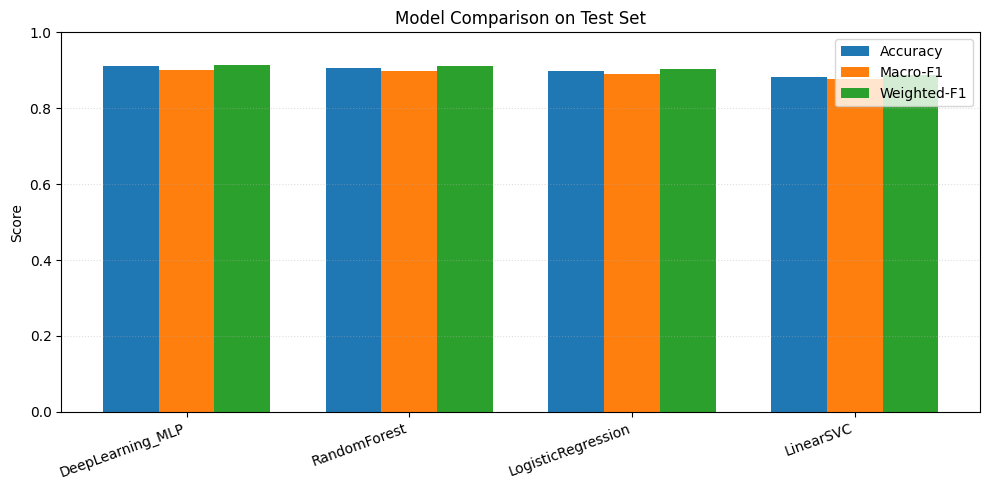

In [17]:
# Step 10: Baseline ML models (LogReg / Linear SVM / RandomForest)
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Load splits if needed (same artifacts used in Step 9)
if (
    ("X_train" not in globals()) or ("y_train" not in globals()) or
    ("X_val" not in globals()) or ("y_val" not in globals()) or
    ("X_test" not in globals()) or ("y_test" not in globals()) or
    ("label_encoder" not in globals())
):
    splits_dir = os.path.join("data", "splits")
    train_fp = os.path.join(splits_dir, "train_split.pkl")
    val_fp   = os.path.join(splits_dir, "val_split.pkl")
    test_fp  = os.path.join(splits_dir, "test_split.pkl")
    le_fp    = os.path.join(splits_dir, "label_encoder.pkl")

    needed = [train_fp, val_fp, test_fp, le_fp]
    missing = [p for p in needed if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError("Missing Step 8 artifacts. Run Step 8 first. Missing: " + ", ".join(missing))

    X_train, y_train, _ = joblib.load(train_fp)
    X_val, y_val, _     = joblib.load(val_fp)
    X_test, y_test, _   = joblib.load(test_fp)
    label_encoder       = joblib.load(le_fp)

labels_in_test = np.unique(y_test).astype(int)
target_names_in_test = [str(label_encoder.classes_[i]) for i in labels_in_test]

def eval_model(name: str, y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    acc = float(accuracy_score(y_true, y_pred))
    f1_macro = float(f1_score(y_true, y_pred, average="macro", labels=labels_in_test, zero_division=0))
    f1_weighted = float(f1_score(y_true, y_pred, average="weighted", labels=labels_in_test, zero_division=0))
    print(f"\n{name}")
    print(f"  accuracy:     {acc:.4f}")
    print(f"  macro-F1:     {f1_macro:.4f}")
    print(f"  weighted-F1:  {f1_weighted:.4f}")
    return {"model": name, "accuracy": acc, "macro_f1": f1_macro, "weighted_f1": f1_weighted}

results = []

# 1) Logistic Regression (strong baseline for standardized tabular features)
logreg = LogisticRegression(
    max_iter=2000,
    n_jobs=None,
    class_weight="balanced",
    multi_class="auto",
    solver="lbfgs",
)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
results.append(eval_model("LogisticRegression", y_test, y_pred_lr))

# 2) Linear SVM (good baseline; works well on many HAR feature sets)
svm = LinearSVC(class_weight="balanced", max_iter=5000)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
results.append(eval_model("LinearSVC", y_test, y_pred_svm))

# 3) Random Forest (nonlinear baseline)
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(eval_model("RandomForest", y_test, y_pred_rf))

# If Step 9 metrics exist in memory, include them in the comparison plot/table
if ("acc_report" in globals()) and ("macro" in globals()) and ("weighted" in globals()):
    try:
        dl_acc = float(globals().get("acc_report"))
        dl_macro_f1 = float(globals().get("macro", {}).get("f1-score", np.nan))
        dl_weighted_f1 = float(globals().get("weighted", {}).get("f1-score", np.nan))
        results.append({"model": "DeepLearning_MLP", "accuracy": dl_acc, "macro_f1": dl_macro_f1, "weighted_f1": dl_weighted_f1})
    except Exception:
        pass

# Summary table
results_sorted = sorted(results, key=lambda d: (d["accuracy"], d["macro_f1"]), reverse=True)
print("\n===== MODEL COMPARISON (TEST) =====")
for r in results_sorted:
    print(f"{r['model']:<18} acc={r['accuracy']:.4f}  macroF1={r['macro_f1']:.4f}  weightedF1={r['weighted_f1']:.4f}")

# Detailed report for the best baseline (among baselines only)
baseline_only = [r for r in results_sorted if r["model"] in {"LogisticRegression", "LinearSVC", "RandomForest"}]
if baseline_only:
    best_name = baseline_only[0]["model"]
    best_pred = {"LogisticRegression": y_pred_lr, "LinearSVC": y_pred_svm, "RandomForest": y_pred_rf}[best_name]
    print(f"\nClassification Report (best baseline: {best_name}, TEST labels only):")
    print(classification_report(
        y_test,
        best_pred,
        labels=labels_in_test,
        target_names=target_names_in_test,
        zero_division=0,
    ))

# ------------------------------
# Comparison graph (bar chart)
# ------------------------------
models = [r["model"] for r in results_sorted]
acc_vals = [r["accuracy"] for r in results_sorted]
macro_vals = [r["macro_f1"] for r in results_sorted]
weighted_vals = [r["weighted_f1"] for r in results_sorted]

x = np.arange(len(models))
w = 0.25

plt.figure(figsize=(max(10, 1.5 * len(models)), 5))
plt.bar(x - w, acc_vals, width=w, label="Accuracy")
plt.bar(x,     macro_vals, width=w, label="Macro-F1")
plt.bar(x + w, weighted_vals, width=w, label="Weighted-F1")
plt.xticks(x, models, rotation=20, ha="right")
plt.ylim(0.0, 1.0)
plt.ylabel("Score")
plt.title("Model Comparison on Test Set")
plt.grid(axis="y", linestyle=":", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

## Step 11: Additional Visualizations (Optional)

This section generates a few plots using outputs already computed in Step 9/10:
- Training curves (accuracy/loss vs epoch)
- Normalized confusion matrix (percentages)
- Per-class F1 bar chart (test set)

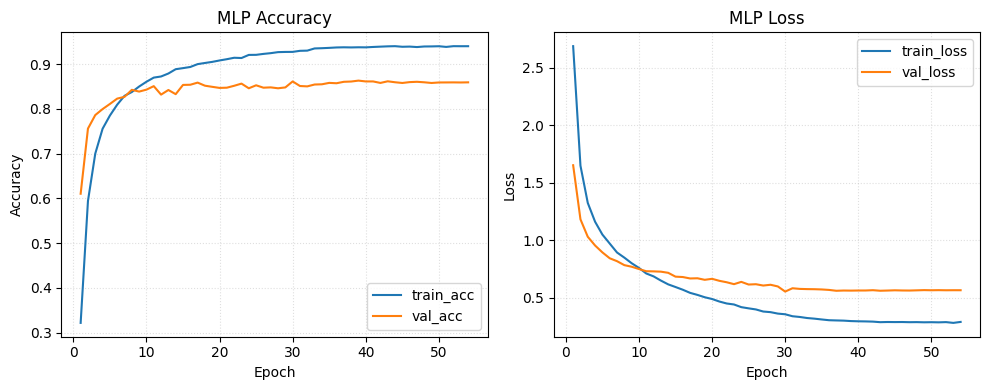

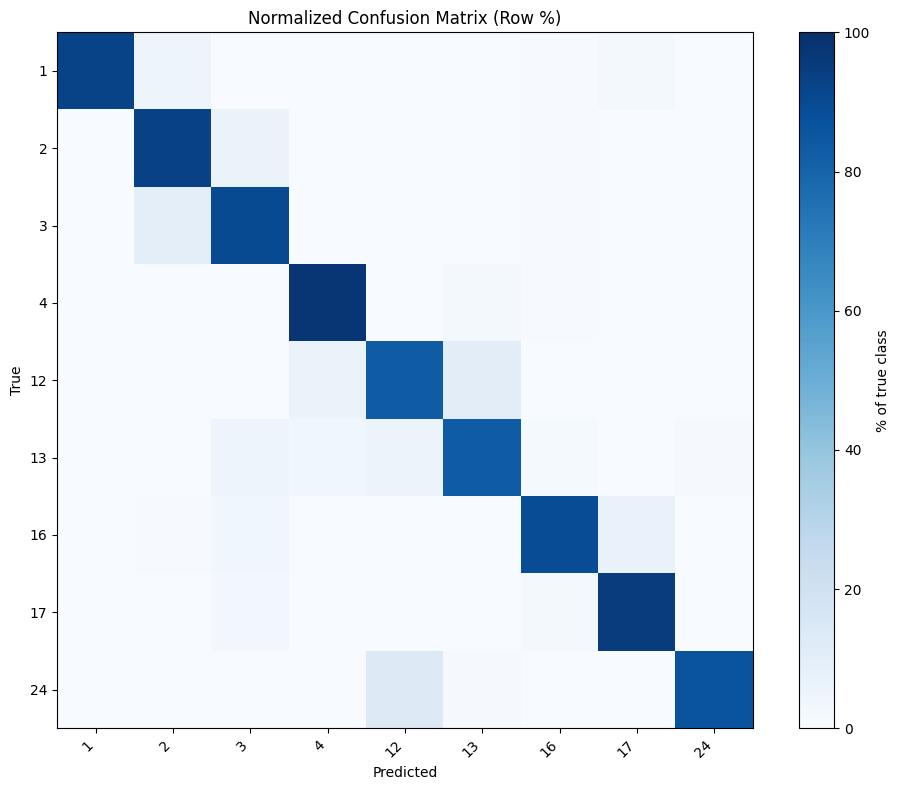

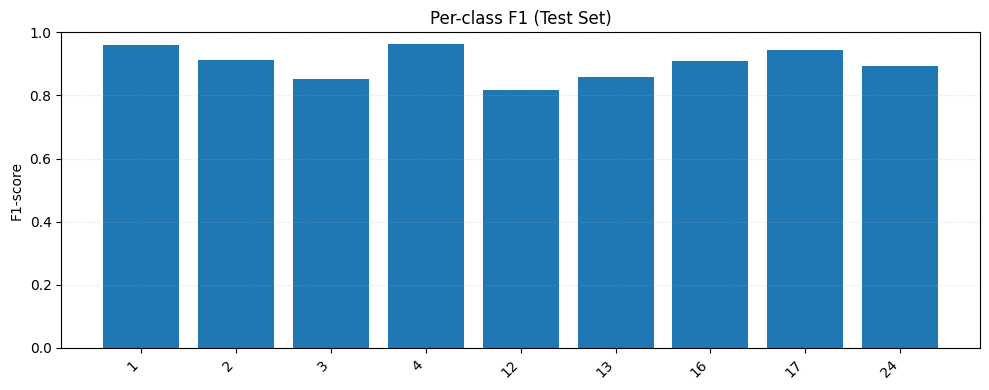

In [18]:
# Step 11: Additional Visualizations (Optional)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------------
# 11.1 Training curves (Step 9)
# ------------------------------
if "history" in globals() and hasattr(history, "history") and isinstance(history.history, dict):
    hist = history.history
    epochs = np.arange(1, len(hist.get("loss", [])) + 1)
    if len(epochs) > 0:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hist.get("accuracy", []), label="train_acc")
        plt.plot(epochs, hist.get("val_accuracy", []), label="val_acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("MLP Accuracy")
        plt.grid(True, linestyle=":", alpha=0.4)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist.get("loss", []), label="train_loss")
        plt.plot(epochs, hist.get("val_loss", []), label="val_loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("MLP Loss")
        plt.grid(True, linestyle=":", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No training history found (run Step 9 first to plot training curves).")

# ---------------------------------------------------
# 11.2 Normalized confusion matrix (percent of row)
# ---------------------------------------------------
if ("y_test" in globals()) and ("y_test_pred" in globals()):
    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_test_pred)
    labels_in_test = np.unique(y_true).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=labels_in_test)
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm, np.maximum(row_sums, 1), dtype=float)
    cm_norm = cm_norm * 100.0
    # tick labels: use original class labels if available, else use encoded indices
    if "label_encoder" in globals():
        tick_labels = [str(label_encoder.classes_[i]) for i in labels_in_test]
    else:
        tick_labels = [str(i) for i in labels_in_test]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=100)
    plt.title("Normalized Confusion Matrix (Row %)")
    plt.colorbar(label="% of true class")
    plt.xticks(np.arange(len(tick_labels)), tick_labels, rotation=45, ha="right")
    plt.yticks(np.arange(len(tick_labels)), tick_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
else:
    print("No test predictions found (run Step 9 first to plot confusion matrix).")

# --------------------------------
# 11.3 Per-class F1 (test set)
# --------------------------------
if ("y_test" in globals()) and ("y_test_pred" in globals()):
    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_test_pred)
    labels_in_test = np.unique(y_true).astype(int)
    if "label_encoder" in globals():
        class_names = [str(label_encoder.classes_[i]) for i in labels_in_test]
    else:
        class_names = [str(i) for i in labels_in_test]

    rep = classification_report(
        y_true, y_pred,
        labels=labels_in_test,
        target_names=class_names,
        zero_division=0,
        output_dict=True,
    )
    f1_vals = [rep[name]["f1-score"] for name in class_names if name in rep]
    plt.figure(figsize=(max(10, 0.6 * len(class_names)), 4))
    plt.bar(class_names, f1_vals)
    plt.ylim(0.0, 1.0)
    plt.ylabel("F1-score")
    plt.title("Per-class F1 (Test Set)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()

## Step 12: Final Summary (Test Set)

This step collects the test-set results from Step 9 and Step 10 and prints a small summary table, including which model performed best.

In [19]:
# Step 12: Final Summary (Test Set)
import numpy as np
import pandas as pd

# Collect MLP metrics from Step 9 (if available)
mlp_row = None
if ("acc_report" in globals()) and ("macro" in globals()) and ("weighted" in globals()):
    try:
        mlp_row = {
            "model": "MLP",
            "accuracy": float(acc_report),
            "macro_f1": float(globals().get("macro", {}).get("f1-score", np.nan)),
            "weighted_f1": float(globals().get("weighted", {}).get("f1-score", np.nan)),
        }
    except Exception:
        mlp_row = None

# Collect baseline results from Step 10 (if available)
baseline_rows = []
if "results_sorted" in globals() and isinstance(results_sorted, list) and len(results_sorted) > 0:
    for r in results_sorted:
        if not isinstance(r, dict) or "model" not in r:
            continue
        name = r.get("model")
        if name in {"LogisticRegression", "LinearSVC", "RandomForest"}:
            baseline_rows.append({
                "model": name,
                "accuracy": float(r.get("accuracy", np.nan)),
                "macro_f1": float(r.get("macro_f1", np.nan)),
                "weighted_f1": float(r.get("weighted_f1", np.nan)),
            })

# Build final table (MLP + all baselines)
rows = []
if mlp_row is not None:
    rows.append(mlp_row)
rows.extend(baseline_rows)

if not rows:
    raise RuntimeError("No results found. Run Step 9 and Step 10 first.")

summary = pd.DataFrame(rows)
summary = summary[["model", "accuracy", "macro_f1", "weighted_f1"]]
summary = summary.round(4)
print("===== FINAL SUMMARY (TEST) =====")
display(summary)

# Identify best baseline and best overall
best_baseline = None
if baseline_rows:
    best_baseline = sorted(baseline_rows, key=lambda d: (d["accuracy"], d["macro_f1"]), reverse=True)[0]

best_overall = summary.sort_values(["accuracy", "macro_f1"], ascending=False).iloc[0]
print("\nBest overall (by accuracy, then macro-F1):")
print(best_overall.to_dict())
if best_baseline is not None:
    print("\nBest baseline (by accuracy, then macro-F1):")
    print(best_baseline)

# Print MLP vs best baseline gaps (if available)
if (mlp_row is not None) and (best_baseline is not None):
    gap_acc = float(mlp_row["accuracy"]) - float(best_baseline["accuracy"])
    gap_macro = float(mlp_row["macro_f1"]) - float(best_baseline["macro_f1"])
    gap_weighted = float(mlp_row["weighted_f1"]) - float(best_baseline["weighted_f1"])
    print("\nMLP vs best baseline gaps (MLP - baseline):")
    print(f"  accuracy:    {gap_acc:+.4f}")
    print(f"  macro-F1:    {gap_macro:+.4f}")
    print(f"  weighted-F1: {gap_weighted:+.4f}")

===== FINAL SUMMARY (TEST) =====


,model,accuracy,macro_f1,weighted_f1
0,MLP,0.9111,0.9009,0.9132
1,RandomForest,0.9050,0.8990,0.9100
2,LogisticRegression,0.8989,0.8896,0.9022
3,LinearSVC,0.8828,0.8758,0.8877



Best overall (by accuracy, then macro-F1):
{'model': 'MLP', 'accuracy': 0.9111, 'macro_f1': 0.9009, 'weighted_f1': 0.9132}

Best baseline (by accuracy, then macro-F1):
{'model': 'RandomForest', 'accuracy': 0.9050263815606776, 'macro_f1': 0.8990312612175659, 'weighted_f1': 0.909982905476194}

MLP vs best baseline gaps (MLP - baseline):
  accuracy:    +0.0061
  macro-F1:    +0.0019
  weighted-F1: +0.0032


## Step 13: Label Mapping (Encoded → Original Activity ID)

The confusion matrices and classification reports use **encoded class indices** (e.g., 0–8).
This table maps each encoded index back to the **original activity label** from the dataset.

In [20]:
# Step 13: Label Mapping (Encoded → Original Activity ID)
import pandas as pd

if "label_encoder" not in globals():
    raise RuntimeError("label_encoder not found. Run the preprocessing/splitting step that fits and saves the LabelEncoder first.")

classes = list(getattr(label_encoder, "classes_", []))
if len(classes) == 0:
    raise RuntimeError("label_encoder.classes_ is empty. Make sure the LabelEncoder was fitted.")

label_map = pd.DataFrame({
    "encoded_index": list(range(len(classes))),
    "original_activity_id": classes,
})

print("===== LABEL MAPPING =====")
display(label_map)

===== LABEL MAPPING =====


,encoded_index,original_activity_id
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6
6,6,7
7,7,12
8,8,13
9,9,16


## Step 14: Error Analysis (Where the Model Confuses Classes)

This step summarizes *which classes are most commonly confused* on the test set. It extracts the largest off-diagonal entries from the confusion matrix and reports them with the original activity IDs.

In [21]:
# Step 14: Error Analysis (Where the Model Confuses Classes)
import numpy as np
import pandas as pd

# Pick y_true / y_pred from whatever is available in the notebook state
y_true_local = None
y_pred_local = None
if "y_true" in globals():
    y_true_local = np.asarray(y_true)
elif "y_test" in globals():
    y_true_local = np.asarray(y_test)

if "y_pred" in globals():
    y_pred_local = np.asarray(y_pred)
elif "y_test_pred" in globals():
    y_pred_local = np.asarray(y_test_pred)
elif "best_pred" in globals():
    y_pred_local = np.asarray(best_pred)

if y_true_local is None or y_pred_local is None:
    raise RuntimeError("Could not find y_true/y_pred. Run the Step 9 evaluation cell first.")

# Labels used for analysis = labels that appear in the test set (keeps tables compact)
labels_used = np.unique(y_true_local)
labels_used = np.sort(labels_used)

# If a confusion matrix already exists and matches these labels, reuse it; otherwise compute one
cm_local = None
if "cm" in globals():
    try:
        cm_candidate = np.asarray(cm)
        if cm_candidate.ndim == 2 and cm_candidate.shape[0] == cm_candidate.shape[1] == len(labels_used):
            cm_local = cm_candidate
    except Exception:
        cm_local = None

if cm_local is None:
    from sklearn.metrics import confusion_matrix
    cm_local = confusion_matrix(y_true_local, y_pred_local, labels=labels_used)

# Map encoded -> original activity id (if label_encoder exists)
encoded_to_original = {}
if "label_encoder" in globals() and hasattr(label_encoder, "classes_"):
    classes_ = list(label_encoder.classes_)
    for enc_idx in labels_used:
        if 0 <= int(enc_idx) < len(classes_):
            encoded_to_original[int(enc_idx)] = classes_[int(enc_idx)]
        else:
            encoded_to_original[int(enc_idx)] = int(enc_idx)
else:
    for enc_idx in labels_used:
        encoded_to_original[int(enc_idx)] = int(enc_idx)

# Per-class summary (support + recall)
row_sums_local = cm_local.sum(axis=1)
diag_local = np.diag(cm_local)
recall_local = np.where(row_sums_local > 0, diag_local / row_sums_local, np.nan)

per_class = pd.DataFrame({
    "encoded": labels_used.astype(int),
    "original_activity_id": [encoded_to_original[int(i)] for i in labels_used],
    "support": row_sums_local.astype(int),
    "recall": recall_local,
}).sort_values(["recall", "support"], ascending=[True, False]).reset_index(drop=True)

print("===== PER-CLASS RECALL (LOWEST FIRST) =====")
display(per_class.round({"recall": 4}))

# Top confusions (largest off-diagonal counts)
confusions = []
for i, enc_true in enumerate(labels_used.astype(int)):
    for j, enc_pred in enumerate(labels_used.astype(int)):
        if i == j:
            continue
        count = int(cm_local[i, j])
        if count <= 0:
            continue
        total_true = int(row_sums_local[i])
        pct_of_true = (count / total_true) if total_true > 0 else np.nan
        confusions.append({
            "true_encoded": enc_true,
            "true_original": encoded_to_original[int(enc_true)],
            "pred_encoded": enc_pred,
            "pred_original": encoded_to_original[int(enc_pred)],
            "count": count,
            "pct_of_true": pct_of_true,
        })

confusions_df = pd.DataFrame(confusions)
if confusions_df.empty:
    print("\nNo off-diagonal errors found (perfect classification on these labels).")
else:
    confusions_df = confusions_df.sort_values(["count", "pct_of_true"], ascending=False).reset_index(drop=True)
    print("\n===== TOP CONFUSIONS (MOST FREQUENT MISCLASSIFICATIONS) =====")
    display(confusions_df.head(15).round({"pct_of_true": 4}))

===== PER-CLASS RECALL (LOWEST FIRST) =====


,encoded,original_activity_id,support,recall
0,7,12,201,0.8308
1,8,13,302,0.8311
2,11,24,121,0.8595
3,9,16,406,0.8892
4,2,3,410,0.8951
5,0,1,440,0.9250
6,1,2,574,0.9303
7,10,17,558,0.9498
8,3,4,575,0.9739



===== TOP CONFUSIONS (MOST FREQUENT MISCLASSIFICATIONS) =====


,true_encoded,true_original,pred_encoded,pred_original,count,pct_of_true
0,2,3,1,2,40,0.0976
1,1,2,2,3,37,0.0645
2,9,16,10,17,27,0.0665
3,7,12,8,13,21,0.1045
4,0,1,1,2,21,0.0477
5,8,13,7,12,18,0.0596
6,10,17,2,3,17,0.0305
7,11,24,7,12,16,0.1322
8,8,13,2,3,15,0.0497
9,9,16,2,3,15,0.0369


## Step 15: Final Conclusion + Limitations + Future Work

This final step generates a short conclusion paragraph using the metrics computed earlier (MLP + baselines) and adds concise limitations and future work points.

In [22]:
# Step 15: Final Conclusion + Limitations + Future Work
import numpy as np
import pandas as pd

# --- Pull key metrics if available ---
mlp_acc = globals().get("acc_report", np.nan)
mlp_macro = float(globals().get("macro", {}).get("f1-score", np.nan)) if "macro" in globals() else np.nan
mlp_weighted = float(globals().get("weighted", {}).get("f1-score", np.nan)) if "weighted" in globals() else np.nan

# Baselines (Step 10)
baseline_rows_local = []
if "baseline_rows" in globals() and isinstance(baseline_rows, list):
    baseline_rows_local = baseline_rows
elif "results_sorted" in globals() and isinstance(results_sorted, list):
    for r in results_sorted:
        if isinstance(r, dict) and r.get("model") in {"LogisticRegression", "LinearSVC", "RandomForest"}:
            baseline_rows_local.append({
                "model": r.get("model"),
                "accuracy": float(r.get("accuracy", np.nan)),
                "macro_f1": float(r.get("macro_f1", np.nan)),
                "weighted_f1": float(r.get("weighted_f1", np.nan)),
            })

best_baseline_local = None
if baseline_rows_local:
    best_baseline_local = sorted(baseline_rows_local, key=lambda d: (d.get("accuracy", -1), d.get("macro_f1", -1)), reverse=True)[0]

# --- Optional: top confusion pair (if we can compute it quickly) ---
top_confusion_text = None
try:
    if "cm" in globals() and "label_encoder" in globals() and hasattr(label_encoder, "classes_") and "y_true" in globals():
        cm_local = np.asarray(cm)
        y_true_local = np.asarray(y_true)
        labels_used = np.sort(np.unique(y_true_local)).astype(int)
        # only proceed if cm shape matches labels_used
        if cm_local.ndim == 2 and cm_local.shape[0] == cm_local.shape[1] == len(labels_used):
            cm_off = cm_local.copy()
            np.fill_diagonal(cm_off, 0)
            idx = np.unravel_index(np.argmax(cm_off), cm_off.shape)
            i, j = int(idx[0]), int(idx[1])
            count = int(cm_off[i, j])
            if count > 0:
                enc_true = int(labels_used[i])
                enc_pred = int(labels_used[j])
                true_id = int(label_encoder.classes_[enc_true]) if enc_true < len(label_encoder.classes_) else enc_true
                pred_id = int(label_encoder.classes_[enc_pred]) if enc_pred < len(label_encoder.classes_) else enc_pred
                top_confusion_text = f"The most common confusion was activity {true_id} predicted as {pred_id} ({count} windows)."
except Exception:
    top_confusion_text = None

# --- Compose conclusion ---
parts = []
parts.append("Conclusion (Test Set):")

if not (np.isnan(mlp_acc) and np.isnan(mlp_macro) and np.isnan(mlp_weighted)):
    parts.append(
        f"The MLP achieved {float(mlp_acc):.4f} test accuracy with macro-F1 {float(mlp_macro):.4f} and weighted-F1 {float(mlp_weighted):.4f} on unseen subjects."
    )
else:
    parts.append("The deep learning MLP achieved strong test performance on unseen subjects (see Step 9 metrics above).")

if best_baseline_local is not None:
    parts.append(
        f"Among the classical baselines, the best was {best_baseline_local['model']} (accuracy {best_baseline_local['accuracy']:.4f}, macro-F1 {best_baseline_local['macro_f1']:.4f})."
    )
    if not np.isnan(mlp_acc):
        gap = float(mlp_acc) - float(best_baseline_local['accuracy'])
        parts.append(f"Compared with the best baseline, the MLP improved accuracy by {gap:+.4f}.")
else:
    parts.append("Baseline models were trained for comparison in Step 10.")

if top_confusion_text is not None:
    parts.append(top_confusion_text)
else:
    parts.append("Most remaining errors come from confusing similar activities, which is typical in HAR using window-level summary features.")

parts.append("Overall, the results indicate the model generalizes well under a subject-independent split.")

print("\n".join(parts))

print("\nLimitations:")
print("- Window-level mean/std features may miss fine temporal patterns.")
print("- Some activities can be under-represented for certain subjects, affecting evaluation stability.")
print("- Label 0 (transition/unknown) should be excluded if present, depending on dataset rules.")

print("\nFuture work:")
print("- Try temporal models (1D-CNN / LSTM) directly on sequences instead of summary stats.")
print("- Perform hyperparameter search and calibration; report confidence intervals across multiple splits.")

Conclusion (Test Set):
The MLP achieved 0.9111 test accuracy with macro-F1 0.9009 and weighted-F1 0.9132 on unseen subjects.
Among the classical baselines, the best was RandomForest (accuracy 0.9050, macro-F1 0.8990).
Compared with the best baseline, the MLP improved accuracy by +0.0061.
The most common confusion was activity 3 predicted as 2 (40 windows).
Overall, the results indicate the model generalizes well under a subject-independent split.

Limitations:
- Window-level mean/std features may miss fine temporal patterns.
- Some activities can be under-represented for certain subjects, affecting evaluation stability.
- Label 0 (transition/unknown) should be excluded if present, depending on dataset rules.

Future work:
- Try temporal models (1D-CNN / LSTM) directly on sequences instead of summary stats.
- Perform hyperparameter search and calibration; report confidence intervals across multiple splits.


# Requirements Checklist (Assignment Alignment)

Use this as a quick map from the assignment requirements to where they are addressed in the notebook.

- Subject-independent split (no subject leakage): **Step 8** (fixed subject train/val/test split)
- Dataset exploration & visualization: **Step 5** (class distribution), **Step 5B** (sensor EDA), **Step 11** (training curves / confusion matrix / per-class F1)
- Missing-value handling: **Step 1/4** (subject-wise HR forward-fill + filtering transient), **Step 7** (`nanmean/nanstd`), **Step 8** (train-only imputation)
- Normalization / scaling: **Step 8** (`StandardScaler` fit on train only, applied to val/test)
- Class imbalance handling: **Step 8** (train-only class weights), **Step 9** (uses class weights in training)
- Feature extraction / engineering: **Step 6** (feature selection), **Step 7** (windowed mean/std statistics)
- Model training + evaluation (accuracy/precision/recall/F1): **Step 9** (MLP + report + confusion matrix), **Step 10** (baseline ML models), **Step 12** (final summary table)
- Error analysis / insights: **Step 14** (top confusions), **Step 15** (limitations + future work)

Notes:
- This notebook uses **window-level summary features (mean/std)** rather than a sequence model (CNN/RNN). This still leverages time structure via windowing, but does not explicitly model within-window temporal order.
- Subject demographics are not used as features (optional in the assignment). Data augmentation is not applied (optional/suggested).